# Multiclass Classification

Multiclass classification performed using:

* Multi-layer Perceptron
* Logistic Regression
* Linear Discriminant Analysis (LDA)
* Quadratic Discriminant Analysis (QDA)


The following implementation works for any number of classes.

## Import dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Set random seed

In [2]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Arguments regarding data, model and training

In [3]:
N = 512
epochs = 25
iters = 150
learning_rate = 0.001
# Number of features
d = 5
# Number of classes
nc = 5
# Minibatch size
bsz = 64
device = torch.device('cuda')

## Generate the Data

In [4]:
def generate_qda_data(N, nc, d):
  mu = torch.randn([nc, d]) * 10
  cov = torch.randn([nc, d, d]) * 5
  cov = cov.transpose(-2, -1) @ cov

  def sample_data(sz, nc):
    X = []
    y = []

    for i in range(nc):
      p = np.random.multivariate_normal(mu[i], cov[i], size=sz)
      X.append(p)
      y.append(np.zeros_like(p[:,0]) + i)

    return torch.Tensor(X).view(-1, d), torch.Tensor(y).view(-1)

  X_train, y_train = sample_data(N, nc)
  X_val, y_val = sample_data(N, nc)
  return X_train, y_train, X_val, y_val, nc, d

In [5]:
def create_spiral_dataset(N, K, sigma):
  """
  Function to simulate spiral dataset

  Args:
    K: int
      Number of classes
    sigma: float
      Standard deviation
    N: int
      Number of data points

  Returns:
    X: torch.tensor
      Spiral data
    y: torch.tensor
      Corresponding ground truth
  """

  # Initialize t, X, y
  N = N * 2
  t = torch.linspace(0, 1, N)
  X = torch.zeros(K*N, 2)
  y = torch.zeros(K*N)

  # Create data
  for k in range(K):
    X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    y[k*N:(k+1)*N] = k

  idx = np.arange(K*N)
  np.random.shuffle(idx)

  return X[idx[:(N * K) // 2]], y[idx[:(N * K) // 2]], X[idx[(N * K) // 2 + 1:]], y[idx[(N * K) // 2 + 1:]], K, 2

In [6]:
# X_train, y_train, X_val, y_val, nc, d = generate_qda_data(N, nc, d)
X_train, y_train, X_val, y_val, nc, d = create_spiral_dataset(N, nc, 0.1)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

torch.Size([2560, 2])
torch.Size([2560])
torch.Size([2559, 2])
torch.Size([2559])


## Visualize Data

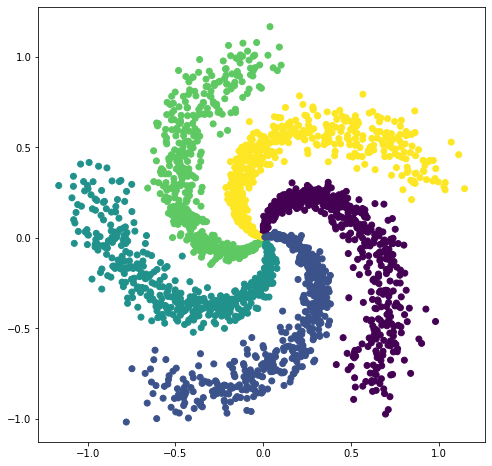

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

## Plotting function

In [8]:
def c_matrix(pred, y):
  
  cm = confusion_matrix(pred, y)#, normalize='all')

  plt.figure(figsize=(10, 9))
  ax = sns.heatmap(cm, annot=True, cmap='PuRd', fmt='g')

  ax.set_title('Confusion Matrix\n\n');
  ax.set_xlabel('\nPredicted Labels')
  ax.set_ylabel('Actual Labels ');

  ax.xaxis.set_ticklabels(range(1, nc+1))
  ax.yaxis.set_ticklabels(range(1, nc+1))

  plt.show()

## Helper functions

In [9]:
def minibatch(X, y, num_points):
  """
  Sample a minibatch of size num_point from the provided input-target data

  Args:
    X: Tensor
      Multi-dimensional tensor containing the input data
    y: Tensor
      1D tensor containing the labels
    num_points: Integer
      Number of elements to be included in minibatch

  Returns:
    batch_x: Tensor
      Minibatch inputs
    batch_y: Tensor
      Minibatch targets
  """
  # Sample a collection of IID indices from the existing data
  batch_indices = np.random.choice(len(X), num_points)
  # Use batch_indices to extract entries from the input and target data tensors
  batch_x = X[batch_indices]
  batch_y = y[batch_indices]

  return batch_x, batch_y

In [10]:
def accuracy(pred, y):
  """
  Function to calculate the accuracy of model predictions

  Args:
    pred: Torch tensor
      model predictions
    y: Torch tensor
      Grouth truth labels 
  
  Returns:
    a: float
      accuracy of model predictions
  """
 
  a = torch.eq(pred, y.long()).double().mean() * 100

  return a

# Multiclass classification using MLP

In [11]:
class MLP(nn.Module):
  """
   A neural network with a single hidden layer
   Structure is as follows:
   nn.Sequential(
        nn.Linear(input_size, hidden_size) + nn.ReLU(), # Fully connected layer with ReLU activation
        nn.Linear(hidden_size, output_size) # Final fully connected layer
    )
  """
  def __init__(self, input_size, hidden_size, output_size):
    """
    Initializing the parameters of MLP

    Args:
      input_size: Int
        Number of input features
      hidden_size: Int
        Number of units in the hidden layer
      output_size: Int
        Number of output features

    Returns:
      Nothing
    """
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        D-dimensional tensor of features

    Returns:
      Torch tensor of model predictions
    """

    return self.layers(x)

In [12]:
# Creating an instance
mlp = MLP(input_size = X_train.shape[1], hidden_size = 64, output_size = nc).to(device)
# Create Adam optimizer function
adam_optimizer = torch.optim.Adam(mlp.parameters(), lr= learning_rate)
# Create a cross entropy loss function
criterion = nn.CrossEntropyLoss()

In [13]:
def train(X, y, model, criterion, optimizer, iters, bsz):
  """
  Training function

  Args:
    X: torch.Tensor
      Features (input) with shape torch.Size([N, d])
    y: torch.Tensor
      Labels (targets) with shape torch.Size([N, 1])
    model: torch nn.Module
      The neural network
    criterion: function
      Loss function
    optimizer: function
      Optimizer
    iters: int
      Number of training iterations
    bsz: int
      Number of elements in the minibatch

  Returns:
    avg_loss: float
      Average loss over all iters
    acc: float
      Training accuracy
  """
  model.train()  
  X = X.to(device)
  y = y.to(device)

  loss_record = [] # Keeping records of loss
  acc_record = [] # Keeping records of accuracy
  
  for i in range(iters):
    
    # Extract minibatch data and labels
    batch_X, batch_y = minibatch(X, y, bsz)
    
    # Reset all gradients to zero
    optimizer.zero_grad()
    
    # Forward pass (Compute the output of the model on the features (inputs))
    y_pred = model(batch_X)
    
    # Compute the loss
    loss = criterion(y_pred, batch_y.long())
    
    # Perform backpropagation and compute the gradients
    loss.backward()

    # Optimizer takes a tiny step in the steepest direction (negative of gradient) and "updates" the weights and biases of the network
    optimizer.step()

    loss_record.append(loss.item())
    acc_record.append(accuracy(torch.argmax(y_pred, dim=1), batch_y).item())

  # Compute average loss over all iterations
  avg_loss = np.sum(loss_record) / iters
  avg_acc = np.sum(acc_record) / iters

  return avg_loss, avg_acc

def eval(X, y, model, criterion, flag):
  """
  Function to gauge network performance

  Args:
    X: torch.tensor
      Features (input)
    y: torch.tensor
      Labels (targets)
    model: torch nn.Module
      The neural network
    criterion: function
      Loss function
    flag: bool
      Flag for plotting confusion matrix

  Returns:
    eval_loss: float 
      Scalar loss value over (X, y) using the model 
    eval_acc: float
      Validation accuracy
  """

  model.eval()

  with torch.no_grad():
    X = X.cuda()
    y = y.cuda()
    y_pred = model(X)
  
    eval_loss = criterion(y_pred, y.long()).item()
  
    # Compute accuracy
    eval_acc = accuracy(torch.argmax(y_pred,dim=1), y)

    if flag:
      plot = c_matrix(torch.argmax(y_pred,dim=1).cpu(), y.cpu())

  return eval_loss, eval_acc

Epoch: 0 train loss: 1.41 Validation loss: 1.14 train accuracy: 48.21 validation accuracy: 55.10
Epoch: 1 train loss: 0.95 Validation loss: 0.87 train accuracy: 54.61 validation accuracy: 53.34
Epoch: 2 train loss: 0.79 Validation loss: 0.76 train accuracy: 56.01 validation accuracy: 57.17
Epoch: 3 train loss: 0.70 Validation loss: 0.69 train accuracy: 61.01 validation accuracy: 61.78
Epoch: 4 train loss: 0.64 Validation loss: 0.63 train accuracy: 65.47 validation accuracy: 66.24
Epoch: 5 train loss: 0.56 Validation loss: 0.57 train accuracy: 71.34 validation accuracy: 69.71
Epoch: 6 train loss: 0.52 Validation loss: 0.52 train accuracy: 74.66 validation accuracy: 74.01
Epoch: 7 train loss: 0.47 Validation loss: 0.47 train accuracy: 79.03 validation accuracy: 79.60
Epoch: 8 train loss: 0.43 Validation loss: 0.43 train accuracy: 82.73 validation accuracy: 81.71
Epoch: 9 train loss: 0.39 Validation loss: 0.40 train accuracy: 85.31 validation accuracy: 84.99
Epoch: 10 train loss: 0.35 Val

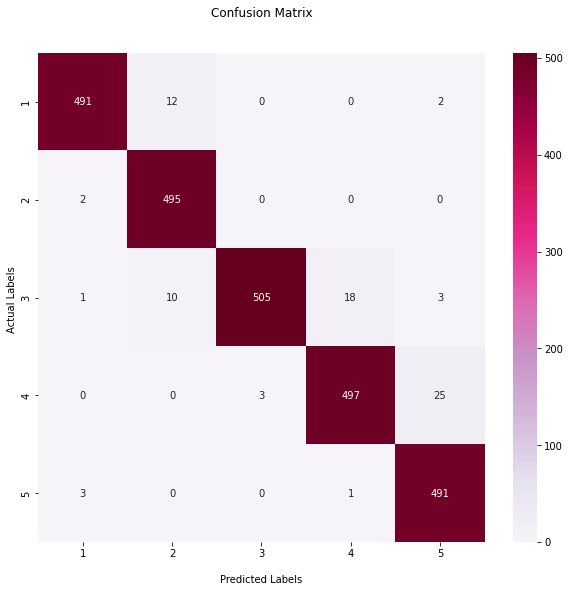

Epoch: 24 train loss: 0.15 Validation loss: 0.16 train accuracy: 97.43 validation accuracy: 96.87


In [14]:
def main(model, optimizer, criterion, epochs, iters, X_train, X_val, y_train, y_val, bsz):
  """
  Train the model and tests the learned model
    
    Args:
      model: torch nn.Module
        The neural network
      optimizer: function
        optimizer
      criterion: function
        Loss function
      epochs: int
        number of training and validation iterations
      iters: int
        Number of training iterations
      X_train: torch.Tensor
        Training features (input)
      X_val: torch.Tensor
        Validation features (input)
      y_train: torch.tensor
        Training labels (targets)
      y_val: torch.tensor
        Validation labels (targets)
      bsz: int
        Number of elements in the minibatch

    Returns:
      Nothing
  """
  for i in range(epochs):
    if i == epochs - 1: flag = True
    else: flag = False
    losses, train_acc = train(X_train, y_train, model, criterion, optimizer, iters, bsz)
    val_loss, val_acc = eval(X_val, y_val, model, criterion, flag)
    print(f'Epoch: {i} train loss: {losses:.2f} Validation loss: {val_loss:.2f} train accuracy: {train_acc:.2f} validation accuracy: {val_acc:.2f}')

main(mlp, adam_optimizer, criterion, epochs, iters, X_train, X_val, y_train, y_val, bsz)

# Multiclass Classification using Logistic Regression

In [15]:
class LogisticReg(nn.Module):
 
  # A single layer neural network
 
  def __init__(self, input_size, output_size):

    """
    Initializing the parameters of the network

    Args:
      input_size: Int
        Number of input features
      output_size: Int
        Number of output features

    Returns:
      Nothing
    """
    super(LogisticReg, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_size, output_size)
    )

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        D-dimensional tensor of features

    Returns:
      Torch tensor of model predictions
    """

    return self.layers(x)

In [16]:
# Creating an instance
net = LogisticReg(input_size = X_train.shape[1], output_size = nc).to(device)
# Create a cross entropy loss function
criterion = nn.CrossEntropyLoss()
# Adam optimizer
adam_optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)

Epoch: 0 train loss: 1.68 Validation loss: 1.63 train accuracy: 22.28 validation accuracy: 23.60
Epoch: 1 train loss: 1.59 Validation loss: 1.54 train accuracy: 24.07 validation accuracy: 26.18
Epoch: 2 train loss: 1.51 Validation loss: 1.48 train accuracy: 31.26 validation accuracy: 35.87
Epoch: 3 train loss: 1.44 Validation loss: 1.42 train accuracy: 34.81 validation accuracy: 36.65
Epoch: 4 train loss: 1.39 Validation loss: 1.37 train accuracy: 39.58 validation accuracy: 44.20
Epoch: 5 train loss: 1.35 Validation loss: 1.33 train accuracy: 43.55 validation accuracy: 45.29
Epoch: 6 train loss: 1.31 Validation loss: 1.29 train accuracy: 45.06 validation accuracy: 46.54
Epoch: 7 train loss: 1.27 Validation loss: 1.26 train accuracy: 46.85 validation accuracy: 47.67
Epoch: 8 train loss: 1.24 Validation loss: 1.23 train accuracy: 48.21 validation accuracy: 48.34
Epoch: 9 train loss: 1.21 Validation loss: 1.20 train accuracy: 48.45 validation accuracy: 49.00
Epoch: 10 train loss: 1.18 Val

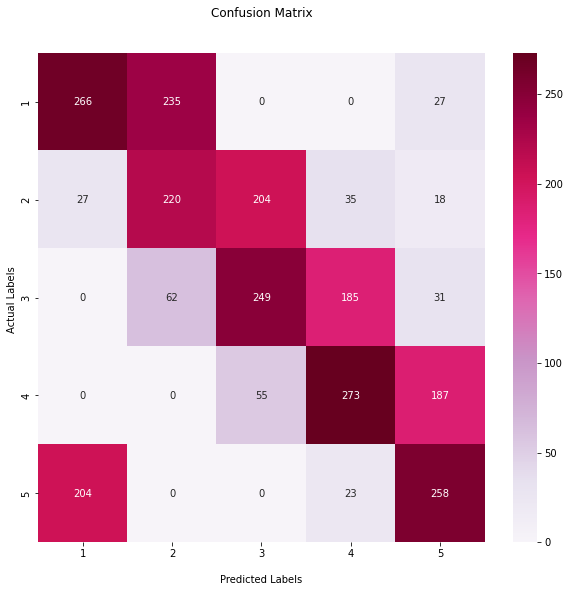

Epoch: 24 train loss: 0.96 Validation loss: 0.98 train accuracy: 51.26 validation accuracy: 49.47


In [17]:
# Main loop
main(net, adam_optimizer, criterion, epochs, iters, X_train, X_val, y_train, y_val, bsz)

# Linear or "Fisher" Discriminant Analysis (LDA)

In [18]:
class LDA():

  def __init__(self, X, y):

    # Initialize parameters
    self.prior = torch.zeros(nc)
    self.mean = torch.zeros(nc, d)
    self.cov = torch.zeros(d, d)

    # Number of classes
    self.classes = torch.unique(y).int()

    # Calculate the parameters for each class
    for c in self.classes:
      X_c = X[y == c]
      self.prior[c] = X_c.shape[0] / X.shape[0]
      self.mean[c] = torch.mean(X_c, axis=0)
      self.cov += torch.cov(X_c.T, correction=0) * self.prior[c]

  def predict(self, X):

    # Predict the most likely class
    
    preds = []
  
    for x in X:
      posts = []
      for c in self.classes: 
        priors = torch.log(self.prior[c])
        inv_cov = torch.linalg.pinv(self.cov)
        inv_cov_det = torch.linalg.det(inv_cov)
        diff = x - self.mean[c]
        likelihood = 0.5 * torch.log(inv_cov_det) - 0.5 * diff.T @ inv_cov @ diff
        post = priors + likelihood
        posts.append(post)
        
      posts = torch.tensor(posts)
      pred = self.classes[torch.argmax(posts)]
      preds.append(pred)
    
    preds = torch.tensor(preds)
    
    
    return preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)


Train Accuracy: 51.80
Validation Accuracy: 48.89


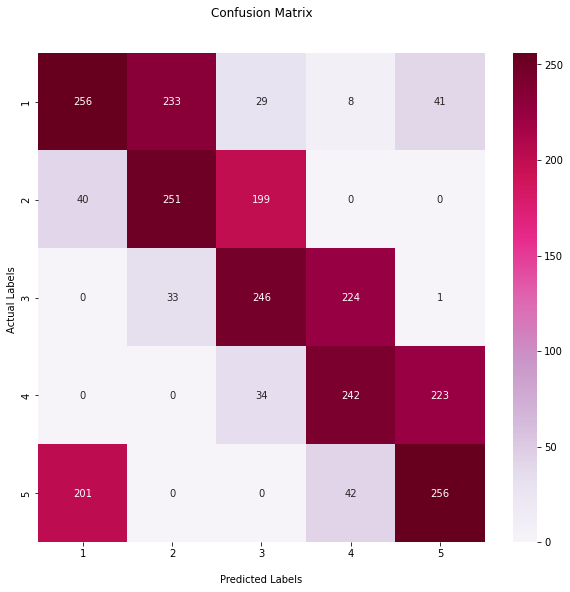

3.835892915725708


In [19]:
start = time()
lda = LDA(X_train, y_train)
pred = lda.predict(X_train)
print(f'Train Accuracy: {accuracy(pred, y_train):.2f}')
pred = lda.predict(X_val)
print(f'Validation Accuracy: {accuracy(pred, y_val):.2f}')
plot = c_matrix(pred, y_val)
print(time() - start)

# Quadratic Discriminant Analysis (QDA)

In [20]:
class QDA():

  def __init__(self, X, y):

    # Initialize parameters
    
    self.prior = torch.zeros(nc)
    self.mean = torch.zeros(nc, d)
    self.cov = torch.zeros(nc, X.shape[1], X.shape[1])
    
    self.classes = torch.unique(y).int()

    for c in self.classes:
      X_c = X[y == c]
      self.prior[c] = X_c.shape[0] / X.shape[0]
      self.mean[c] = torch.mean(X_c, axis=0)
      self.cov[c] = torch.cov(X_c.T, correction=0)

  def predict(self, X):

    # Predict the most likely class

    preds = []
  
    for x in X:
      posts = []
      for c in self.classes: 
        priors = torch.log(self.prior[c])
        inv_cov = torch.linalg.pinv(self.cov[c])
        inv_cov_det = torch.linalg.det(inv_cov)
        diff = x - self.mean[c]
        likelihood = 0.5 * torch.log(inv_cov_det) - 0.5*diff.T @ inv_cov @ diff
        post = priors + likelihood
        posts.append(post)
        
      posts = torch.tensor(posts)
      pred = self.classes[torch.argmax(posts)]
      preds.append(pred)
    preds = torch.tensor(preds)
    return preds


Train Accuracy: 70.82
Validation Accuracy: 68.58


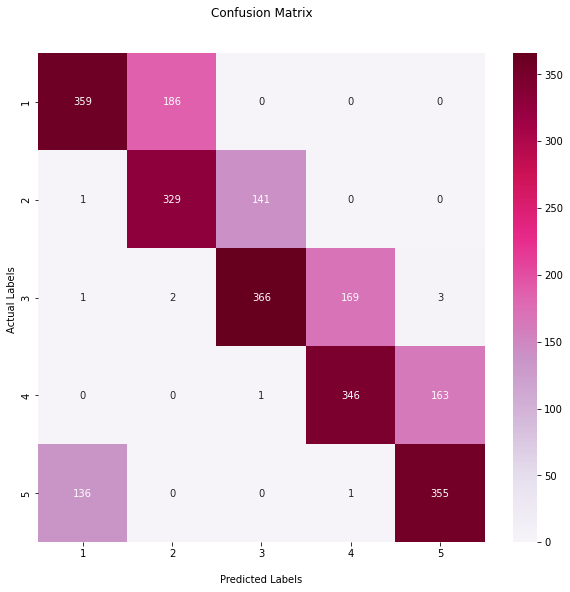

3.882542133331299


In [21]:
start = time()
qda = QDA(X_train, y_train)
pred = qda.predict(X_train)
print(f'Train Accuracy: {accuracy(pred, y_train):.2f}')
pred = qda.predict(X_val)
print(f'Validation Accuracy: {accuracy(pred, y_val):.2f}')
plot = c_matrix(pred, y_val)
print(time() - start)

LDA and QDA using broadcasting (faster runtime)

In [22]:
class LDA_QDA:
  def __init__(self, X, y, shared_cov=False):
    self.pi = self.mle_pi(y)
    self.mu = self.mle_mean(X, y)
    self.cov = self.mle_cov(X, y, shared_cov)

  def mle_pi(self, y):
    # y: Shape [N]
    # Return Shape [C]

    y = F.one_hot(y.long()).double() # Shape [N, C]
    return y.mean(dim = 0)

  def mle_mean(self, X, y):
    # X: Shape [N, d]
    # y: Shape [N]
    # Return Shape [C, d]

    X = X.unsqueeze(1) # Shape [N, 1, d]
    y = F.one_hot(y.long()).double().unsqueeze(2) # Shape [N, C, 1]

    means = (X * y).sum(dim = 0) / y.sum(dim = 0)
    return means

  def mle_cov(self, X, y, shared_cov):
    # X: Shape [N, d]
    # y: Shape [N]
    # Return Shape [C, d, d]

    y = F.one_hot(y.long()).double().unsqueeze(2) # Shape [N, C, 1]
    X = X.unsqueeze(1).repeat(1, y.shape[1], 1) - self.mu.unsqueeze(0) # Shape [N, C, d]

    X = (X * y).unsqueeze(-1) # Shape [N, C, d, 1]
    cov = torch.matmul(X, X.transpose(-2, -1)) # Shape [N, C, d, d]
    if shared_cov:
      cov = cov.sum(dim = 0).sum(dim=0, keepdim=True) / y.shape[0]
      cov = cov.repeat(y.shape[1], 1, 1)
    else:
      cov = cov.sum(dim = 0) / y.sum(dim = 0).unsqueeze(-1)

    return cov

  def predict(self, X):
    # X: Shape [N, d]

    cov_inv = torch.linalg.inv(self.cov)

    predict = torch.log(self.pi).unsqueeze(0).repeat(X.shape[0], 1)
    predict += 0.5 * cov_inv.logdet()
    X = X.unsqueeze(1).repeat(1, self.pi.shape[0], 1) - self.mu.unsqueeze(0)
    theta = torch.matmul(X.unsqueeze(2), cov_inv.unsqueeze(0))
    theta = torch.matmul(theta, X.unsqueeze(-1)).squeeze()
    predict -= 0.5 * theta
    return predict.argmax(dim = 1)

QDA Train Accuracy: 70.82
QDA Validation Accuracy: 68.58


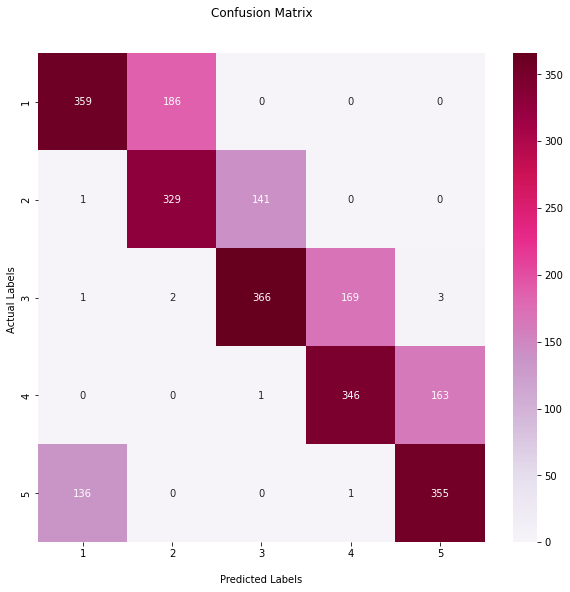

0.2665739059448242


In [23]:
start = time()
qda = LDA_QDA(X_train, y_train, shared_cov=False)
y_val_pred = qda.predict(X_val)
y_train_pred = qda.predict(X_train)

print(f"QDA Train Accuracy: {accuracy(y_train_pred, y_train):.2f}")
print(f"QDA Validation Accuracy: {accuracy(y_val_pred, y_val):.2f}")
plot = c_matrix(y_val_pred, y_val)
print(time() - start)

LDA Train Accuracy: 51.80
LDA Validation Accuracy: 48.89


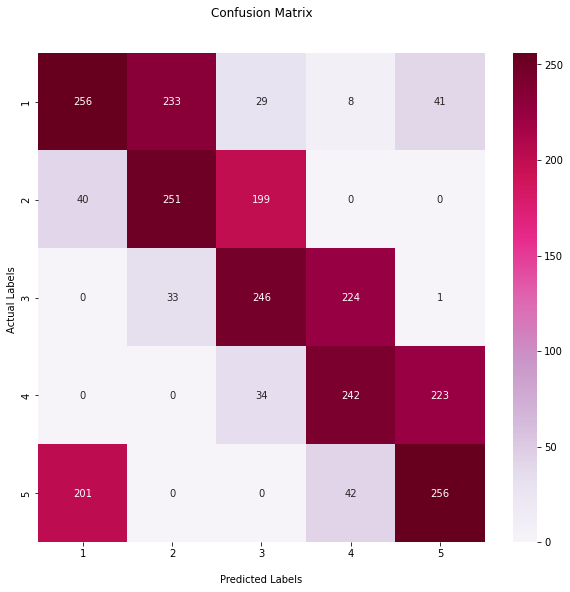

0.26093482971191406


In [24]:
start = time()
lda = LDA_QDA(X_train, y_train, shared_cov=True)
y_val_pred = lda.predict(X_val)
y_train_pred = lda.predict(X_train)

print(f"LDA Train Accuracy: {accuracy(y_train_pred, y_train):.2f}")
print(f"LDA Validation Accuracy: {accuracy(y_val_pred, y_val):.2f}")
plot = c_matrix(y_val_pred, y_val)
print(time() - start)